In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
#import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.model_selection import cross_val_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
from sklearn.feature_selection import RFE

import gc
import random
import re
from typing import List ,Dict, Tuple

from sklearn.metrics import *
from sklearn.model_selection import KFold, StratifiedKFold

# 한글 폰트 설정
from statsmodels import robust
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

import sys
import shap
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
import sklearn

In [2]:
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- tensorflow: {tf.__version__}")
print(f"- shap: {shap.__version__}")

- os: Windows-10-10.0.19041-SP0
- python: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
- pandas: 1.2.4
- numpy: 1.19.5
- sklearn: 1.0.2
- tensorflow: 2.7.0
- shap: 0.40.0


In [3]:
pip list 
# catboost   1.0.4

Package                            Version
---------------------------------- -------------------
-rpcio                             1.41.1
absl-py                            0.15.0
alabaster                          0.7.12
alembic                            1.4.1
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
arviz                              0.11.4
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autokeras                          1.0.16.post1
autopep8                           1.5.6
Babel                         

In [4]:
SEED = 20182830

d_code = pd.read_csv('속성_D_코드.csv')
h_code = pd.read_csv('속성_H_코드.csv')
l_code = pd.read_csv('속성_L_코드.csv')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape , test.shape

((501951, 35), (46404, 34))

## preprocessing & engineering

### 순서형 변수 처리
단순히 category 형태가 아닌 ordinal 처리

In [5]:
train['person_attribute_a_1'] = train['person_attribute_a_1'].astype(pd.CategoricalDtype(ordered=True))
train['person_attribute_b'] = train['person_attribute_b'].astype(pd.CategoricalDtype(ordered=True))
train['person_prefer_e'] = train['person_prefer_e'].astype(pd.CategoricalDtype(ordered=True))
train['contents_attribute_e'] = train['contents_attribute_e'].astype(pd.CategoricalDtype(ordered=True))

In [6]:
test['person_attribute_a_1'] = test['person_attribute_a_1'].astype(pd.CategoricalDtype(ordered=True))
test['person_attribute_b'] = test['person_attribute_b'].astype(pd.CategoricalDtype(ordered=True))
test['person_prefer_e'] = test['person_prefer_e'].astype(pd.CategoricalDtype(ordered=True))
test['contents_attribute_e'] = test['contents_attribute_e'].astype(pd.CategoricalDtype(ordered=True))

### person_rn, content_rn
* 사람과 컨텐츠의 조합에 관해 특성을 만들어야함

In [7]:
train['person_contents_mul'] = train['person_rn'] * train['contents_rn']
test['person_contents_mul'] = test['person_rn'] * test['contents_rn']

### 회원속성 - 컨텐츠 속성 일치 여부 

In [8]:
d_code.columns = ['attribute_d', 'attribute_d_d', 'attribute_d_s', 'attribute_d_m', 'attribute_d_l']
h_code.columns = ['attribute_h', 'attribute_h_m', 'attribute_h_l']
l_code.columns = ['attribute_l', 'attribute_l_d', 'attribute_l_s', 'attribute_l_m', 'attribute_l_l']

In [9]:
def merge_codes(df : pd.DataFrame, 
                df_code : pd.DataFrame,
                col : str) -> pd.DataFrame:
    df = df.copy()
    df_code = df_code.copy()
    df_code = df_code.add_prefix(f"{col}_")
    df_code.columns.values[0] = col
    return pd.merge(df, df_code, how="left", on=col)

In [10]:
def preprocess_data(
                    df : pd.DataFrame, 
                    is_train : bool = True, 
                    cols_merge : List[Tuple[str, pd.DataFrame]] = [], 
                    cols_equi : List[Tuple[str, str]] = [] ,
                    cols_drop : List[str] = ['id', 'person_prefer_f', 'person_prefer_g', 'contents_open_dt']
                    ) -> Tuple[pd.DataFrame, np.ndarray]:
    df = df.copy()

    y_data = None
    if is_train:
        y_data = df['target'].to_numpy()
        df = df.drop(columns='target')

    for col, df_code in cols_merge:
        df = merge_codes(df, df_code, col)

    cols = df.select_dtypes(bool).columns.tolist()
    df[cols] = df[cols].astype(int)

    for col1, col2 in cols_equi:
        df[f'{col1}_{col2}'] = (df[col1] == df[col2]).astype(int)
        df[f'{col1}_{col2}_squared'] = (df[col1].astype(int) - df[col2].astype(int))**2

    df = df.drop(columns=cols_drop)
    return (df, y_data)

In [11]:
# 소분류 중분류 대분류 속성코드 merge 컬럼명 및 데이터 프레임 리스트
cols_merge = [
              ('person_prefer_d_1', d_code),
              ('person_prefer_d_2', d_code),
              ('person_prefer_d_3', d_code),
              ('contents_attribute_d', d_code),
              ('person_prefer_h_1', h_code),
              ('person_prefer_h_2', h_code),
              ('person_prefer_h_3', h_code),
              ('contents_attribute_h', h_code),
              ('contents_attribute_l', l_code),
]

# 회원 속성과 콘텐츠 속성의 동일한 코드 여부에 대한 컬럼명 리스트
cols_equi = [

    ('contents_attribute_c', 'person_prefer_c'),
    ('contents_attribute_e', 'person_prefer_e'),

    ('person_prefer_d_2_attribute_d_d', 'contents_attribute_d_attribute_d_d'),
    ('person_prefer_d_2_attribute_d_s', 'contents_attribute_d_attribute_d_s'),
    ('person_prefer_d_2_attribute_d_m', 'contents_attribute_d_attribute_d_m'),
    ('person_prefer_d_2_attribute_d_l', 'contents_attribute_d_attribute_d_l'),
    ('person_prefer_d_3_attribute_d_d', 'contents_attribute_d_attribute_d_d'),
    ('person_prefer_d_3_attribute_d_s', 'contents_attribute_d_attribute_d_s'),
    ('person_prefer_d_3_attribute_d_m', 'contents_attribute_d_attribute_d_m'),
    ('person_prefer_d_3_attribute_d_l', 'contents_attribute_d_attribute_d_l'),

    ('person_prefer_h_2_attribute_h_m', 'contents_attribute_h_attribute_h_m'),
    ('person_prefer_h_2_attribute_h_l', 'contents_attribute_h_attribute_h_l'),
    ('person_prefer_h_3_attribute_h_m', 'contents_attribute_h_attribute_h_m'),
    ('person_prefer_h_3_attribute_h_l', 'contents_attribute_h_attribute_h_l'),

]

# 학습에 필요없는 컬럼 리스트
cols_drop = ['id', 'person_prefer_f', 'person_prefer_g', 'contents_rn']

In [12]:
x_train, y_train = preprocess_data(train, cols_merge=cols_merge, cols_equi=cols_equi, cols_drop=cols_drop)
x_test, _ = preprocess_data(test, is_train=False, cols_merge=cols_merge, cols_equi=cols_equi, cols_drop=cols_drop)
x_train.shape, y_train.shape, x_test.shape

((501951, 87), (501951,), (46404, 87))

## 시간

In [13]:
x_train["contents_open_dt_hour"] = x_train["contents_open_dt"].apply(lambda x:x.split(" ")[1][:2])
x_train["contents_open_dt_day"] = x_train["contents_open_dt"].apply(lambda x:x.split("-")[2][:2])
x_train["contents_open_dt_month"] = x_train["contents_open_dt"].apply(lambda x:x.split("-")[1])

x_test["contents_open_dt_hour"] = x_test["contents_open_dt"].apply(lambda x:x.split(" ")[1][:2])
x_test["contents_open_dt_day"] = x_test["contents_open_dt"].apply(lambda x:x.split("-")[2][:2])
x_test["contents_open_dt_month"] = x_test["contents_open_dt"].apply(lambda x:x.split("-")[1])

In [14]:
x_train = x_train.drop(["contents_open_dt"],axis = 1)

x_test = x_test.drop(["contents_open_dt"],axis = 1)

## 매칭 T/F 카운트

In [15]:
x_train["d_match_count"] = x_train["d_l_match_yn"] + x_train["d_m_match_yn"] + x_train["d_s_match_yn"]

x_test["d_match_count"] = x_test["d_l_match_yn"] + x_test["d_m_match_yn"] + x_test["d_s_match_yn"]

In [16]:
x_train["h_match_count"] = x_train["h_l_match_yn"] + x_train["h_m_match_yn"] + x_train["h_s_match_yn"]

x_test["h_match_count"] = x_test["h_l_match_yn"] + x_test["h_m_match_yn"] + x_test["h_s_match_yn"]

## 선호특징과 컨탠츠 특징을 구성
### 둘의 합

In [17]:
x_train["person_prefer_mul"] = (x_train["person_prefer_c"].astype("int")**2) * (x_train["person_prefer_e"].astype("int")**3)

x_test["person_prefer_mul"] = (x_test["person_prefer_c"].astype("int")**2) * (x_test["person_prefer_e"].astype("int")**3)


In [18]:
x_train["person_prefer_mul"] = (x_train["person_prefer_c"].astype("int")**2) * (x_train["person_prefer_e"].astype("int")**3)

x_test["person_prefer_mul"] = (x_test["person_prefer_c"].astype("int")**2) * (x_test["person_prefer_e"].astype("int")**3)

In [19]:
x_train["contents_attribute_mul"] = (x_train["contents_attribute_j_1"].astype("int")) * (x_train["contents_attribute_a"].astype("int"))\
* (x_train["contents_attribute_i"].astype("int")) * (x_train["contents_attribute_c"].astype("int")) * (x_train["contents_attribute_k"].astype("int"))\
* (x_train["contents_attribute_m"].astype("int")) * (x_train["contents_attribute_e"].astype("int"))

x_test["contents_attribute_mul"] = (x_test["contents_attribute_j_1"].astype("int")) * (x_test["contents_attribute_a"].astype("int"))\
* (x_test["contents_attribute_i"].astype("int")) * (x_test["contents_attribute_c"].astype("int")) * (x_test["contents_attribute_k"].astype("int"))\
* (x_test["contents_attribute_m"].astype("int")) * (x_test["contents_attribute_e"].astype("int"))

In [20]:
x_train["prefer_attribute_com"] = x_train["person_prefer_mul"] + x_train["contents_attribute_mul"]

x_test["prefer_attribute_com"] = x_test["person_prefer_mul"] + x_test["contents_attribute_mul"]

### 대중소세 코드 값 가지고

In [21]:
x_train['person_D_code1_sum'] = x_train['person_prefer_d_1_attribute_d_l'] + x_train['person_prefer_d_1_attribute_d_m'] \
                                + x_train['person_prefer_d_1_attribute_d_s'] + x_train['person_prefer_d_1_attribute_d_d'] + x_train['person_prefer_d_1']
x_train['person_D_code2_sum'] = x_train['person_prefer_d_2_attribute_d_l'] + x_train['person_prefer_d_2_attribute_d_m'] \
                                + x_train['person_prefer_d_2_attribute_d_s'] + x_train['person_prefer_d_2_attribute_d_d'] + x_train['person_prefer_d_2']
x_train['person_D_code3_sum'] = x_train['person_prefer_d_3_attribute_d_l'] + x_train['person_prefer_d_3_attribute_d_m'] \
                                + x_train['person_prefer_d_3_attribute_d_s'] + x_train['person_prefer_d_3_attribute_d_d'] + x_train['person_prefer_d_3']

x_test['person_D_code1_sum'] = x_test['person_prefer_d_1_attribute_d_l'] + x_test['person_prefer_d_1_attribute_d_m'] \
                               + x_test['person_prefer_d_1_attribute_d_s'] + x_test['person_prefer_d_1_attribute_d_d'] + x_test['person_prefer_d_1']
x_test['person_D_code2_sum'] = x_test['person_prefer_d_2_attribute_d_l'] + x_test['person_prefer_d_2_attribute_d_m'] \
                               + x_test['person_prefer_d_2_attribute_d_s'] + x_test['person_prefer_d_2_attribute_d_d'] + x_test['person_prefer_d_2']
x_test['person_D_code3_sum'] = x_test['person_prefer_d_3_attribute_d_l'] + x_test['person_prefer_d_3_attribute_d_m'] \
                               + x_test['person_prefer_d_3_attribute_d_s'] + x_test['person_prefer_d_3_attribute_d_d'] + x_test['person_prefer_d_3']

In [22]:
x_train['person_H_code1_sum'] = x_train['person_prefer_h_1_attribute_h_l'] + x_train['person_prefer_h_1_attribute_h_m'] + x_train['person_prefer_h_1']
x_train['person_H_code2_sum'] = x_train['person_prefer_h_2_attribute_h_l'] + x_train['person_prefer_h_2_attribute_h_m'] + x_train['person_prefer_h_2']
x_train['person_H_code3_sum'] = x_train['person_prefer_h_3_attribute_h_l'] + x_train['person_prefer_h_3_attribute_h_m'] + x_train['person_prefer_h_3']

x_test['person_H_code1_sum'] = x_test['person_prefer_h_1_attribute_h_l'] + x_test['person_prefer_h_1_attribute_h_m'] + x_test['person_prefer_h_1']
x_test['person_H_code2_sum'] = x_test['person_prefer_h_2_attribute_h_l'] + x_test['person_prefer_h_2_attribute_h_m'] + x_test['person_prefer_h_2']
x_test['person_H_code3_sum'] = x_test['person_prefer_h_3_attribute_h_l'] + x_test['person_prefer_h_3_attribute_h_m'] + x_test['person_prefer_h_3']

In [23]:
x_train['content_D_code_sum'] = x_train['contents_attribute_d_attribute_d_l'] + x_train['contents_attribute_d_attribute_d_m'] \
                                + x_train['contents_attribute_d_attribute_d_s'] + x_train['contents_attribute_d_attribute_d_d'] + x_train['contents_attribute_d']

x_test['content_D_code_sum'] = x_test['contents_attribute_d_attribute_d_l'] + x_test['contents_attribute_d_attribute_d_m'] \
                               + x_test['contents_attribute_d_attribute_d_s'] + x_test['contents_attribute_d_attribute_d_d'] + x_test['contents_attribute_d']

In [24]:
x_train['content_H_code_sum'] = x_train['contents_attribute_h_attribute_h_l'] + x_train['contents_attribute_h_attribute_h_m'] + x_train['contents_attribute_h']

x_test['content_H_code_sum'] = x_test['contents_attribute_h_attribute_h_l'] + x_test['contents_attribute_h_attribute_h_m'] + x_test['contents_attribute_h']

In [25]:
x_train['content_L_code_sum'] = x_train['contents_attribute_l_attribute_l_l'] + x_train['contents_attribute_l_attribute_l_m'] \
                                + x_train['contents_attribute_l_attribute_l_s'] + x_train['contents_attribute_l_attribute_l_d'] + x_train['contents_attribute_l']

x_test['content_L_code_sum'] = x_test['contents_attribute_l_attribute_l_l'] + x_test['contents_attribute_l_attribute_l_m'] \
                               + x_test['contents_attribute_l_attribute_l_s'] + x_test['contents_attribute_l_attribute_l_d'] + x_test['contents_attribute_l']

In [26]:
x_train['D1_D_compare'] = np.abs(x_train['person_D_code1_sum'] - x_train['content_D_code_sum'])
x_train['D2_D_compare'] = np.abs(x_train['person_D_code2_sum'] - x_train['content_D_code_sum'])
x_train['D3_D_compare'] = np.abs(x_train['person_D_code3_sum'] - x_train['content_D_code_sum'])
x_train['D_compare'] = x_train['D1_D_compare'] * x_train['D2_D_compare'] * x_train['D3_D_compare']

x_test['D1_D_compare'] = np.abs(x_test['person_D_code1_sum'] - x_test['content_D_code_sum'])
x_test['D2_D_compare'] = np.abs(x_test['person_D_code2_sum'] - x_test['content_D_code_sum'])
x_test['D3_D_compare'] = np.abs(x_test['person_D_code3_sum'] - x_test['content_D_code_sum'])
x_test['D_compare'] = x_test['D1_D_compare'] * x_test['D2_D_compare'] * x_test['D3_D_compare']

In [27]:
x_train['D1_D2_compare'] = np.abs(x_train['person_D_code1_sum'] - x_train['person_D_code2_sum'])
x_train['D1_D3_compare'] = np.abs(x_train['person_D_code1_sum'] - x_train['person_D_code3_sum'])
x_train['D2_D3_compare'] = np.abs(x_train['person_D_code2_sum'] - x_train['person_D_code3_sum'])
x_train['D_D_compare'] = x_train['D1_D2_compare'] * x_train['D1_D3_compare'] * x_train['D2_D3_compare']

x_test['D1_D2_compare'] = np.abs(x_test['person_D_code1_sum'] - x_test['person_D_code2_sum'])
x_test['D1_D3_compare'] = np.abs(x_test['person_D_code1_sum'] - x_test['person_D_code3_sum'])
x_test['D2_D3_compare'] = np.abs(x_test['person_D_code2_sum'] - x_test['person_D_code3_sum'])
x_test['D_D_compare'] = x_test['D1_D2_compare'] * x_test['D1_D3_compare'] * x_test['D2_D3_compare']

In [28]:
x_train['H1_H_compare'] = np.abs(x_train['person_H_code1_sum'] - x_train['content_H_code_sum'])
x_train['H2_H_compare'] = np.abs(x_train['person_H_code2_sum'] - x_train['content_H_code_sum'])
x_train['H3_H_compare'] = np.abs(x_train['person_H_code3_sum'] - x_train['content_H_code_sum'])
x_train['H_compare'] = x_train['H1_H_compare'] * x_train['H2_H_compare'] * x_train['H3_H_compare']

x_test['H1_H_compare'] = np.abs(x_test['person_H_code1_sum'] - x_test['content_H_code_sum'])
x_test['H2_H_compare'] = np.abs(x_test['person_H_code2_sum'] - x_test['content_H_code_sum'])
x_test['H3_H_compare'] = np.abs(x_test['person_H_code3_sum'] - x_test['content_H_code_sum'])
x_test['H_compare'] = x_test['H1_H_compare'] * x_test['H2_H_compare'] * x_test['H3_H_compare']

In [29]:
x_train['H1_H2_compare'] = np.abs(x_train['person_H_code1_sum'] - x_train['person_H_code2_sum'])
x_train['H1_H3_compare'] = np.abs(x_train['person_H_code1_sum'] - x_train['person_H_code3_sum'])
x_train['H2_H3_compare'] = np.abs(x_train['person_H_code2_sum'] - x_train['person_H_code3_sum'])
x_train['H_H_compare'] = x_train['H1_H2_compare'] * x_train['H1_H3_compare'] * x_train['H2_H3_compare']

x_test['H1_H2_compare'] = np.abs(x_test['person_H_code1_sum'] - x_test['person_H_code2_sum'])
x_test['H1_H3_compare'] = np.abs(x_test['person_H_code1_sum'] - x_test['person_H_code3_sum'])
x_test['H2_H3_compare'] = np.abs(x_test['person_H_code2_sum'] - x_test['person_H_code3_sum'])
x_test['H_H_compare'] = x_test['H1_H2_compare'] * x_test['H1_H3_compare'] * x_test['H2_H3_compare']

In [30]:
x_train['D_H_mul'] = x_train['D_compare'] * x_train['H_compare']
x_test['D_H_mul'] = x_test['D_compare'] * x_test['H_compare']

x_train['D_H_sum'] = x_train['D_compare'] + x_train['H_compare']
x_test['D_H_sum'] = x_test['D_compare'] + x_test['H_compare']

In [31]:
drop_lst = ['person_D_code1_sum', 'person_D_code2_sum', 'person_D_code3_sum',
            'person_H_code1_sum', 'person_H_code2_sum', 'person_H_code3_sum',
            'content_D_code_sum', 'content_H_code_sum']

In [32]:
x_train = x_train.drop(drop_lst, axis=1)
x_test = x_test.drop(drop_lst, axis=1)

### 범주형 칼럼 리스트

In [33]:
cat_features = x_train.columns[x_train.nunique() >= 2].tolist()
cat_features

['d_l_match_yn',
 'd_m_match_yn',
 'd_s_match_yn',
 'h_l_match_yn',
 'h_m_match_yn',
 'h_s_match_yn',
 'person_attribute_a',
 'person_attribute_a_1',
 'person_attribute_b',
 'person_prefer_c',
 'person_prefer_d_1',
 'person_prefer_d_2',
 'person_prefer_d_3',
 'person_prefer_e',
 'person_prefer_h_1',
 'person_prefer_h_2',
 'person_prefer_h_3',
 'contents_attribute_i',
 'contents_attribute_a',
 'contents_attribute_j_1',
 'contents_attribute_j',
 'contents_attribute_c',
 'contents_attribute_k',
 'contents_attribute_l',
 'contents_attribute_d',
 'contents_attribute_m',
 'contents_attribute_e',
 'contents_attribute_h',
 'person_rn',
 'person_contents_mul',
 'person_prefer_d_1_attribute_d_d',
 'person_prefer_d_1_attribute_d_s',
 'person_prefer_d_1_attribute_d_m',
 'person_prefer_d_1_attribute_d_l',
 'person_prefer_d_2_attribute_d_d',
 'person_prefer_d_2_attribute_d_s',
 'person_prefer_d_2_attribute_d_m',
 'person_prefer_d_2_attribute_d_l',
 'person_prefer_d_3_attribute_d_d',
 'person_prefer_

In [34]:
cat_features = x_train.columns[x_train.nunique() >= 2].tolist()
cat_features = list(set(cat_features) - set(['D1_D_compare', 'D2_D_compare', 'D3_D_compare', 'D_compare', 
                                             'H1_H_compare', 'H2_H_compare', 'H3_H_compare', 'H_compare',
                                             'D1_D2_compare', 'D1_D3_compare', 'D2_D3_compare', 'D_D_compare',
                                             'H1_H2_compare', 'H1_H3_compare', 'H2_H3_compare', 'H_H_compare',
                                             'D_H_mul', 'D_H_sum', 'content_L_code_sum', 'person_contents_mul',
                                             'person_prefer_d_3_attribute_d_s_contents_attribute_d_attribute_d_s_squared',
                                             'person_prefer_d_3_attribute_d_d_contents_attribute_d_attribute_d_d_squared',
                                             'person_prefer_d_3_attribute_d_m_contents_attribute_d_attribute_d_m_squared',
                                             'person_prefer_h_3_attribute_h_l_contents_attribute_h_attribute_h_l_squared',
                                             'person_prefer_d_3_attribute_d_l_contents_attribute_d_attribute_d_l_squared',
                                             'person_prefer_d_2_attribute_d_d_contents_attribute_d_attribute_d_d_squared',
                                             'person_prefer_h_2_attribute_h_l_contents_attribute_h_attribute_h_l_squared',
                                             'person_prefer_d_2_attribute_d_l_contents_attribute_d_attribute_d_l_squared',
                                             'person_prefer_d_2_attribute_d_m_contents_attribute_d_attribute_d_m_squared',
                                             'person_prefer_h_2_attribute_h_m_contents_attribute_h_attribute_h_m_squared',
                                             'person_prefer_d_2_attribute_d_s_contents_attribute_d_attribute_d_s_squared',
                                             'person_prefer_h_3_attribute_h_m_contents_attribute_h_attribute_h_m_squared',
                                             'contents_attribute_e_person_prefer_e_squared',
                                             'contents_attribute_c_person_prefer_c_squared',
                                              'd_match_count',
                                             'h_match_count',
                                             'person_prefer_mul',
                                             'contents_attribute_mul',
                                             'prefer_attribute_com',
                                            ]))

In [35]:
num_features = ['D1_D_compare', 'D2_D_compare', 'D3_D_compare', 'D_compare', 
                                             'H1_H_compare', 'H2_H_compare', 'H3_H_compare', 'H_compare',
                                             'D1_D2_compare', 'D1_D3_compare', 'D2_D3_compare', 'D_D_compare',
                                             'H1_H2_compare', 'H1_H3_compare', 'H2_H3_compare', 'H_H_compare',
                                             'D_H_mul', 'D_H_sum', 'content_L_code_sum', 'person_contents_mul',
                                             'person_prefer_d_3_attribute_d_s_contents_attribute_d_attribute_d_s_squared',
                                             'person_prefer_d_3_attribute_d_d_contents_attribute_d_attribute_d_d_squared',
                                             'person_prefer_d_3_attribute_d_m_contents_attribute_d_attribute_d_m_squared',
                                             'person_prefer_h_3_attribute_h_l_contents_attribute_h_attribute_h_l_squared',
                                             'person_prefer_d_3_attribute_d_l_contents_attribute_d_attribute_d_l_squared',
                                             'person_prefer_d_2_attribute_d_d_contents_attribute_d_attribute_d_d_squared',
                                             'person_prefer_h_2_attribute_h_l_contents_attribute_h_attribute_h_l_squared',
                                             'person_prefer_d_2_attribute_d_l_contents_attribute_d_attribute_d_l_squared',
                                             'person_prefer_d_2_attribute_d_m_contents_attribute_d_attribute_d_m_squared',
                                             'person_prefer_h_2_attribute_h_m_contents_attribute_h_attribute_h_m_squared',
                                             'person_prefer_d_2_attribute_d_s_contents_attribute_d_attribute_d_s_squared',
                                             'person_prefer_h_3_attribute_h_m_contents_attribute_h_attribute_h_m_squared',
                                             'contents_attribute_e_person_prefer_e_squared',
                                             'contents_attribute_c_person_prefer_c_squared',
                                              'd_match_count',
                                             'h_match_count',
                                             'person_prefer_mul',
                                             'contents_attribute_mul',
                                             'prefer_attribute_com',
                                            ]

### 스케일링

In [36]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted

class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.
    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

In [37]:
scaler = GaussRankScaler()
x_train[num_features] = pd.DataFrame(scaler.fit_transform(x_train[num_features]))
x_test[num_features] = pd.DataFrame(scaler.transform(x_test[num_features]))

x_train[num_features].columns = num_features
x_test[num_features].columns = num_features

### feature selection

In [38]:
model = CatBoostClassifier(random_state=SEED,  eval_metric="F1", cat_features=cat_features, one_hot_max_size=4, verbose=100)

In [39]:
#num_features = list(set(num_features) - set(['H3_H_compare', 'H2_H_compare', 'D_H_mul', 'D3_D_compare', 'D2_D_compare']))
x_train[num_features] = x_train[num_features].astype(float)
x_train[cat_features] = x_train[cat_features].astype(str)

x_test[num_features] = x_test[num_features].astype(float)
x_test[cat_features] = x_test[cat_features].astype(str)

In [40]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(model, threshold='median')
sfm.fit(x_train, y_train)
x_new = sfm.transform(x_train)
x_te_new = sfm.transform(x_test)
feature_idx = sfm.get_support()
feature_name = x_train.columns[feature_idx]

Learning rate set to 0.146594
0:	learn: 0.6129903	total: 3.52s	remaining: 58m 41s
100:	learn: 0.6744988	total: 8m 17s	remaining: 1h 13m 52s
200:	learn: 0.6811379	total: 15m 48s	remaining: 1h 2m 51s
300:	learn: 0.6846696	total: 22m 44s	remaining: 52m 47s
400:	learn: 0.6876104	total: 29m 34s	remaining: 44m 10s
500:	learn: 0.6895202	total: 36m 40s	remaining: 36m 32s
600:	learn: 0.6915085	total: 42m 48s	remaining: 28m 25s
700:	learn: 0.6934531	total: 49m 23s	remaining: 21m 4s
800:	learn: 0.6950350	total: 56m 1s	remaining: 13m 55s
900:	learn: 0.6965364	total: 1h 2m 42s	remaining: 6m 53s
999:	learn: 0.6981956	total: 1h 9m 20s	remaining: 0us


In [41]:
x_new = pd.DataFrame(x_new)
x_te_new = pd.DataFrame(x_te_new)

x_new.columns = feature_name
x_te_new.columns = feature_name

In [42]:
x_new.columns

Index(['person_attribute_a_1', 'person_attribute_b', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_h_1', 'person_prefer_h_2',
       'contents_attribute_a', 'contents_attribute_j_1',
       'contents_attribute_c', 'contents_attribute_l', 'contents_attribute_d',
       'contents_attribute_m', 'contents_attribute_e', 'contents_attribute_h',
       'person_rn', 'person_contents_mul', 'person_prefer_d_1_attribute_d_d',
       'person_prefer_d_1_attribute_d_s', 'person_prefer_d_1_attribute_d_m',
       'person_prefer_d_1_attribute_d_l', 'person_prefer_d_2_attribute_d_d',
       'person_prefer_d_2_attribute_d_s', 'person_prefer_d_3_attribute_d_d',
       'person_prefer_d_3_attribute_d_s', 'contents_attribute_d_attribute_d_d',
       'contents_attribute_d_attribute_d_s',
       'contents_attribute_d_attribute_d_m',
       'contents_attribute_d_attribute_d_l', 'person_prefer_h_1_attribute_h_m',
       'person_p

In [43]:
x_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501951 entries, 0 to 501950
Data columns (total 57 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   person_attribute_a_1                          501951 non-null  object
 1   person_attribute_b                            501951 non-null  object
 2   person_prefer_c                               501951 non-null  object
 3   person_prefer_d_1                             501951 non-null  object
 4   person_prefer_d_2                             501951 non-null  object
 5   person_prefer_d_3                             501951 non-null  object
 6   person_prefer_e                               501951 non-null  object
 7   person_prefer_h_1                             501951 non-null  object
 8   person_prefer_h_2                             501951 non-null  object
 9   contents_attribute_a                          501951 non-nu

In [44]:
x_new.shape,x_te_new.shape

((501951, 57), (46404, 57))

# PCA

In [45]:
# contents_attribute_mul 중 결측치가 존재하는 열만 출력
x_test.loc[x_test['contents_attribute_mul'].isna()]

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,H1_H_compare,H2_H_compare,H3_H_compare,H_compare,H1_H2_compare,H1_H3_compare,H2_H3_compare,H_H_compare,D_H_mul,D_H_sum
23749,0,0,0,1,0,0,2,3,2,5,...,-1.486923,-1.048074,-1.282161,-0.949189,-1.113576,-1.476415,-1.269865,-1.069797,0.013804,0.122441
25360,0,0,0,1,1,1,1,3,3,5,...,-2.751064,-1.452829,-0.827837,-2.751064,-1.420112,-0.779798,-0.729462,-0.608573,-1.893588,0.517660


In [46]:
# contents_attribute_mul는 다음의 식을 따라 만든 열이다.
# contents_attribute_j_1 * contents_attribute_a * contents_attribute_i * contents_attribute_c * contents_attribute_k * contents_attribute_m * contents_attribute_e
# 따라서 이 식에 따라 해당 값을 구했다.

print(9 * 3* 3 * 3 * 2* 4 * 10)
print(9 * 3* 3 * 4 * 2* 4 * 11)

19440
28512


In [47]:
# x_test는 contents_attribute_mul가 int 피쳐이지만 
# x_te_new는 feature selection 과정에서 contents_attribute_mul가 str 피쳐가 됨
# 따라서 위에서 구해준 값을 각 피쳐의 type에 따라 결측치처리를 해줌

x_test.loc[(x_test['contents_attribute_mul'].isna())&(x_test['contents_attribute_e']=='10'),'contents_attribute_mul'] = 19440
x_test.loc[(x_test['contents_attribute_mul'].isna())&(x_test['contents_attribute_e']=='11'),'contents_attribute_mul'] = 28512

x_te_new.loc[(x_te_new['contents_attribute_mul'].isna())&(x_te_new['contents_attribute_e']=='10'),'contents_attribute_mul'] = '19440'
x_te_new.loc[(x_te_new['contents_attribute_mul'].isna())&(x_te_new['contents_attribute_e']=='11'),'contents_attribute_mul'] = '28512'

In [48]:
# 결측치가 없음
x_test.loc[x_test['contents_attribute_mul'].isna()]

,d_l_match_yn,d_m_match_yn,d_s_match_yn,h_l_match_yn,h_m_match_yn,h_s_match_yn,person_attribute_a,person_attribute_a_1,person_attribute_b,person_prefer_c,...,H1_H_compare,H2_H_compare,H3_H_compare,H_compare,H1_H2_compare,H1_H3_compare,H2_H3_compare,H_H_compare,D_H_mul,D_H_sum


#### shap를 사용하여 피쳐 importance를 확인한다

In [49]:
# DF, based on which importance is checked
X_importance = x_new
#Explain model predictions using shap library:
model = CatBoostClassifier(random_state=0).fit(x_new, train.target)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df2 = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df2.columns = ['column_name', 'shap_importance']
importance_df2 = importance_df2.sort_values('shap_importance', ascending=False)
importance_df2

Learning rate set to 0.146594
0:	learn: 0.6867240	total: 130ms	remaining: 2m 9s
1:	learn: 0.6819081	total: 214ms	remaining: 1m 46s
2:	learn: 0.6782823	total: 292ms	remaining: 1m 37s
3:	learn: 0.6754137	total: 371ms	remaining: 1m 32s
4:	learn: 0.6732982	total: 451ms	remaining: 1m 29s
5:	learn: 0.6713591	total: 529ms	remaining: 1m 27s
6:	learn: 0.6699261	total: 608ms	remaining: 1m 26s
7:	learn: 0.6687668	total: 676ms	remaining: 1m 23s
8:	learn: 0.6679112	total: 745ms	remaining: 1m 22s
9:	learn: 0.6669104	total: 819ms	remaining: 1m 21s
10:	learn: 0.6660963	total: 893ms	remaining: 1m 20s
11:	learn: 0.6652585	total: 979ms	remaining: 1m 20s
12:	learn: 0.6646442	total: 1.05s	remaining: 1m 19s
13:	learn: 0.6639533	total: 1.13s	remaining: 1m 19s
14:	learn: 0.6632926	total: 1.21s	remaining: 1m 19s
15:	learn: 0.6627390	total: 1.28s	remaining: 1m 19s
16:	learn: 0.6623145	total: 1.36s	remaining: 1m 18s
17:	learn: 0.6619181	total: 1.43s	remaining: 1m 18s
18:	learn: 0.6614375	total: 1.51s	remaining: 

158:	learn: 0.6439885	total: 12.6s	remaining: 1m 6s
159:	learn: 0.6439333	total: 12.7s	remaining: 1m 6s
160:	learn: 0.6438842	total: 12.8s	remaining: 1m 6s
161:	learn: 0.6438289	total: 12.8s	remaining: 1m 6s
162:	learn: 0.6437526	total: 12.9s	remaining: 1m 6s
163:	learn: 0.6436959	total: 13s	remaining: 1m 6s
164:	learn: 0.6435929	total: 13s	remaining: 1m 5s
165:	learn: 0.6435242	total: 13.1s	remaining: 1m 5s
166:	learn: 0.6434720	total: 13.2s	remaining: 1m 5s
167:	learn: 0.6434049	total: 13.3s	remaining: 1m 5s
168:	learn: 0.6433494	total: 13.4s	remaining: 1m 5s
169:	learn: 0.6432968	total: 13.4s	remaining: 1m 5s
170:	learn: 0.6432392	total: 13.5s	remaining: 1m 5s
171:	learn: 0.6431926	total: 13.6s	remaining: 1m 5s
172:	learn: 0.6431449	total: 13.7s	remaining: 1m 5s
173:	learn: 0.6430848	total: 13.8s	remaining: 1m 5s
174:	learn: 0.6430254	total: 13.8s	remaining: 1m 5s
175:	learn: 0.6429556	total: 13.9s	remaining: 1m 5s
176:	learn: 0.6429003	total: 14s	remaining: 1m 5s
177:	learn: 0.6428

320:	learn: 0.6358083	total: 25.5s	remaining: 53.8s
321:	learn: 0.6357675	total: 25.5s	remaining: 53.8s
322:	learn: 0.6357347	total: 25.6s	remaining: 53.7s
323:	learn: 0.6357009	total: 25.7s	remaining: 53.6s
324:	learn: 0.6356662	total: 25.8s	remaining: 53.5s
325:	learn: 0.6356326	total: 25.8s	remaining: 53.4s
326:	learn: 0.6355795	total: 25.9s	remaining: 53.4s
327:	learn: 0.6355398	total: 26s	remaining: 53.3s
328:	learn: 0.6354987	total: 26.1s	remaining: 53.2s
329:	learn: 0.6354635	total: 26.2s	remaining: 53.1s
330:	learn: 0.6354262	total: 26.2s	remaining: 53s
331:	learn: 0.6353716	total: 26.3s	remaining: 53s
332:	learn: 0.6353402	total: 26.4s	remaining: 52.9s
333:	learn: 0.6353089	total: 26.5s	remaining: 52.8s
334:	learn: 0.6352862	total: 26.6s	remaining: 52.7s
335:	learn: 0.6352453	total: 26.6s	remaining: 52.7s
336:	learn: 0.6352126	total: 26.7s	remaining: 52.6s
337:	learn: 0.6351760	total: 26.8s	remaining: 52.5s
338:	learn: 0.6351393	total: 26.9s	remaining: 52.4s
339:	learn: 0.6351

479:	learn: 0.6300626	total: 38s	remaining: 41.2s
480:	learn: 0.6300243	total: 38.1s	remaining: 41.1s
481:	learn: 0.6299895	total: 38.2s	remaining: 41s
482:	learn: 0.6299687	total: 38.3s	remaining: 40.9s
483:	learn: 0.6299443	total: 38.3s	remaining: 40.9s
484:	learn: 0.6299129	total: 38.4s	remaining: 40.8s
485:	learn: 0.6298722	total: 38.5s	remaining: 40.7s
486:	learn: 0.6298311	total: 38.6s	remaining: 40.6s
487:	learn: 0.6297971	total: 38.7s	remaining: 40.6s
488:	learn: 0.6297628	total: 38.7s	remaining: 40.5s
489:	learn: 0.6297348	total: 38.8s	remaining: 40.4s
490:	learn: 0.6297037	total: 38.9s	remaining: 40.3s
491:	learn: 0.6296658	total: 39s	remaining: 40.3s
492:	learn: 0.6296262	total: 39.1s	remaining: 40.2s
493:	learn: 0.6295987	total: 39.2s	remaining: 40.1s
494:	learn: 0.6295675	total: 39.2s	remaining: 40s
495:	learn: 0.6295075	total: 39.3s	remaining: 40s
496:	learn: 0.6294810	total: 39.4s	remaining: 39.9s
497:	learn: 0.6294499	total: 39.5s	remaining: 39.8s
498:	learn: 0.6294133	

638:	learn: 0.6251082	total: 50.7s	remaining: 28.6s
639:	learn: 0.6250682	total: 50.8s	remaining: 28.6s
640:	learn: 0.6250268	total: 50.8s	remaining: 28.5s
641:	learn: 0.6249977	total: 50.9s	remaining: 28.4s
642:	learn: 0.6249709	total: 51s	remaining: 28.3s
643:	learn: 0.6249474	total: 51.1s	remaining: 28.2s
644:	learn: 0.6249083	total: 51.2s	remaining: 28.2s
645:	learn: 0.6248814	total: 51.3s	remaining: 28.1s
646:	learn: 0.6248601	total: 51.3s	remaining: 28s
647:	learn: 0.6248327	total: 51.4s	remaining: 27.9s
648:	learn: 0.6247982	total: 51.5s	remaining: 27.9s
649:	learn: 0.6247812	total: 51.6s	remaining: 27.8s
650:	learn: 0.6247490	total: 51.6s	remaining: 27.7s
651:	learn: 0.6247229	total: 51.7s	remaining: 27.6s
652:	learn: 0.6246894	total: 51.8s	remaining: 27.5s
653:	learn: 0.6246600	total: 51.9s	remaining: 27.4s
654:	learn: 0.6246357	total: 52s	remaining: 27.4s
655:	learn: 0.6245996	total: 52s	remaining: 27.3s
656:	learn: 0.6245738	total: 52.1s	remaining: 27.2s
657:	learn: 0.624551

800:	learn: 0.6204546	total: 1m 3s	remaining: 15.8s
801:	learn: 0.6204171	total: 1m 3s	remaining: 15.7s
802:	learn: 0.6203839	total: 1m 3s	remaining: 15.6s
803:	learn: 0.6203610	total: 1m 3s	remaining: 15.6s
804:	learn: 0.6203339	total: 1m 3s	remaining: 15.5s
805:	learn: 0.6203101	total: 1m 3s	remaining: 15.4s
806:	learn: 0.6202839	total: 1m 4s	remaining: 15.3s
807:	learn: 0.6202536	total: 1m 4s	remaining: 15.2s
808:	learn: 0.6202241	total: 1m 4s	remaining: 15.2s
809:	learn: 0.6201930	total: 1m 4s	remaining: 15.1s
810:	learn: 0.6201801	total: 1m 4s	remaining: 15s
811:	learn: 0.6201532	total: 1m 4s	remaining: 14.9s
812:	learn: 0.6201149	total: 1m 4s	remaining: 14.8s
813:	learn: 0.6200874	total: 1m 4s	remaining: 14.8s
814:	learn: 0.6200653	total: 1m 4s	remaining: 14.7s
815:	learn: 0.6200413	total: 1m 4s	remaining: 14.6s
816:	learn: 0.6200123	total: 1m 4s	remaining: 14.5s
817:	learn: 0.6199865	total: 1m 4s	remaining: 14.5s
818:	learn: 0.6199558	total: 1m 5s	remaining: 14.4s
819:	learn: 0.

959:	learn: 0.6161325	total: 1m 16s	remaining: 3.17s
960:	learn: 0.6161013	total: 1m 16s	remaining: 3.1s
961:	learn: 0.6160705	total: 1m 16s	remaining: 3.02s
962:	learn: 0.6160447	total: 1m 16s	remaining: 2.94s
963:	learn: 0.6160217	total: 1m 16s	remaining: 2.86s
964:	learn: 0.6159923	total: 1m 16s	remaining: 2.78s
965:	learn: 0.6159610	total: 1m 16s	remaining: 2.7s
966:	learn: 0.6159360	total: 1m 16s	remaining: 2.62s
967:	learn: 0.6159094	total: 1m 16s	remaining: 2.54s
968:	learn: 0.6158881	total: 1m 16s	remaining: 2.46s
969:	learn: 0.6158506	total: 1m 16s	remaining: 2.38s
970:	learn: 0.6158315	total: 1m 17s	remaining: 2.3s
971:	learn: 0.6158056	total: 1m 17s	remaining: 2.22s
972:	learn: 0.6157750	total: 1m 17s	remaining: 2.14s
973:	learn: 0.6157494	total: 1m 17s	remaining: 2.06s
974:	learn: 0.6157252	total: 1m 17s	remaining: 1.98s
975:	learn: 0.6157030	total: 1m 17s	remaining: 1.9s
976:	learn: 0.6156820	total: 1m 17s	remaining: 1.82s
977:	learn: 0.6156388	total: 1m 17s	remaining: 1.7

,column_name,shap_importance
56,D_H_sum,0.156756
10,contents_attribute_j_1,0.124941
51,D_compare,0.107313
6,person_prefer_e,0.073779
42,contents_open_dt_hour,0.071262
50,D1_D_compare,0.070243
41,contents_attribute_e_person_prefer_e_squared,0.069278
46,h_match_count,0.068375
9,contents_attribute_a,0.060093
45,d_match_count,0.058424


#### importance가 0.07 이상인 피쳐만 가지고 PCA를 진행한다

In [50]:
from sklearn.decomposition import PCA
pca1=PCA().fit(x_new[list(importance_df2.query('shap_importance > 0.07').column_name)])
np.cumsum(pca1.explained_variance_ratio_)

array([0.71883801, 0.82575326, 0.91056631, 0.98873913, 0.99595348,
       1.        ])

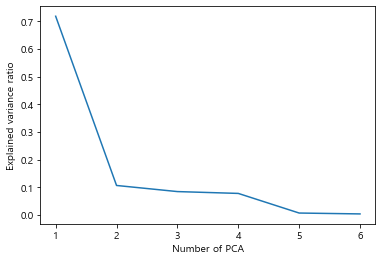

In [51]:
plt.plot(np.arange(1,7), pca1.explained_variance_ratio_)
plt.xlabel('Number of PCA')
plt.ylabel('Explained variance ratio')
plt.show()

In [52]:
pca = PCA()
x_new_pca = pd.DataFrame(pca.fit_transform(x_new[list(importance_df2.query('shap_importance > 0.07').column_name)]))
x_te_new_pca = pd.DataFrame(pca.transform(x_te_new[list(importance_df2.query('shap_importance > 0.07').column_name)]))

# clustering

In [53]:
# 군집의 개수는 임의로 정했다.

from sklearn.cluster import KMeans
km = KMeans(n_clusters=20, random_state = 20182830)

In [54]:
# 앞에서 구한 PCA 열들만 가지고 clustering을 진행한다.

train_km = km.fit_predict(x_new_pca)
test_km = km.predict(x_te_new_pca)

In [55]:
len(train_km), len(test_km), x_new.shape[0], x_te_new.shape[0]

(501951, 46404, 501951, 46404)

In [56]:
x_new['cluster'] = train_km
x_te_new['cluster'] = test_km

In [64]:
x_new.to_csv('x_new.csv', index=False)
x_te_new.to_csv('x_te_new.csv', index=False)

In [ ]:
print((pd.read_csv('x_new.csv')['cluster'] == x_new['cluster']).sum())
print((pd.read_csv('x_te_new.csv')['cluster'] == x_te_new['cluster']).sum())